In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely import *

Найденные районы:
                                          name admin_level
element  id                                               
relation 1635717          Општина Стара Пазова           8
         2027114    Градска општина Стари град           8
         3065611        Градска општина Гроцка           8
         3085424        Градска општина Сурчин           8
         3085749  Градска општина Нови Београд           8
         3085750         Градска општина Земун           8
         5731335        Градска општина Врачар           8
         5892891  Градска општина Савски венац           8
         6930224      Градска општина Звездара           8
         7727516      Градска општина Чукарица           8
         7728561      Градска општина Раковица           8
         7737268      Градска општина Вождовац           8
         7737269      Градска општина Палилула           8


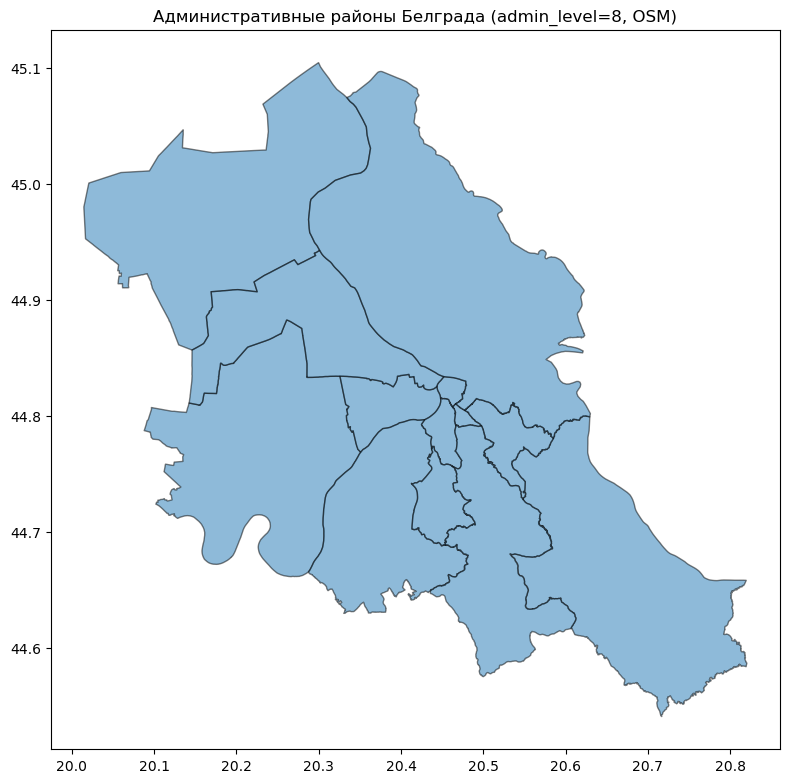

In [2]:
# Чтобы вывод был компактнее
ox.settings.log_console = True
ox.settings.use_cache = True

place_name = "Belgrade, Serbia"

tags = {
    "boundary": "administrative",
    "admin_level": "8",
}

gdf = ox.features_from_place(place_name, tags=tags)

# Оставляем только полигоны
districts = gdf[gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# На всякий случай ещё раз фильтруем по admin_level,
# потому что в выборку могут затесаться другие границы
districts = districts[districts["admin_level"] == "8"]

print("Найденные районы:")
print(districts[["name", "admin_level"]])

# Простая визуализация
ax = districts.plot(figsize=(8, 8), edgecolor="black", alpha=0.5)

# Подпишем названия районов в центре полигона
for _, row in districts.iterrows():
    if row["geometry"] is None:
        continue
    point = row.geometry.representative_point()
    #ax.annotate(
        #text=str(row.get("name", "")),
        #xy=(point.x, point.y),
        #ha="center",
        #fontsize=8,
    #)

plt.title("Административные районы Белграда (admin_level=8, OSM)")
plt.tight_layout()
plt.show()

# Сохранить на диск, чтобы дальше использовать в QGIS / для аналитики
districts = districts[['geometry', 'int_name', 'name']]
#districts.to_file("belgrade_districts.geojson", driver="GeoJSON")

In [3]:
gdf = gpd.read_file('serbia_collisions_2024.geojson')

C:\Users\user\anaconda3\envs\geoanalytics\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 1459246 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [19]:
gdf.crs
gdf = gdf.set_crs(4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

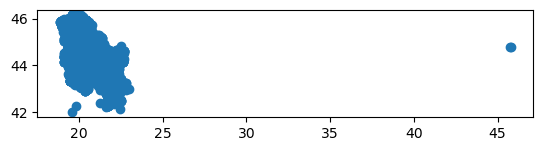

In [20]:
gdf.plot()

<Axes: >

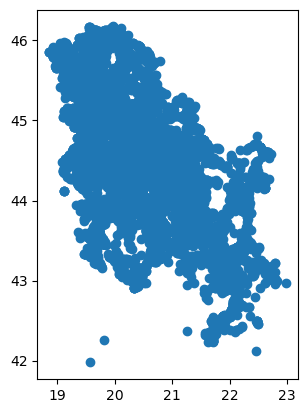

In [21]:
gdf = gdf[gdf['lon'] < 30]
gdf.plot()

<Axes: >

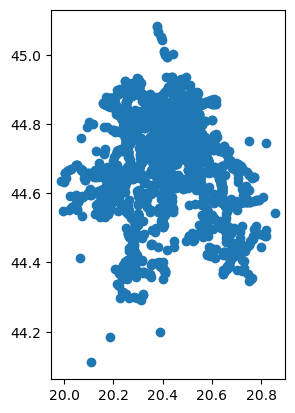

In [22]:
gdf[(gdf['city'] == 'BEOGRAD')&(gdf['lon'] < 21)].plot()

In [4]:
crashes_joined = gdf.sjoin(districts)

crash_counts = (
    crashes_joined
    .groupby("name")
    .size()
    .rename("n_crashes")
    .reset_index()
)

# 2. Добавляем счётчики в GeoDataFrame районов
districts_counts = districts.merge(crash_counts, on="name", how="left")

# Если в каком-то районе не было ни одной аварии — ставим 0
districts_counts["n_crashes"] = districts_counts["n_crashes"].fillna(0).astype(int)

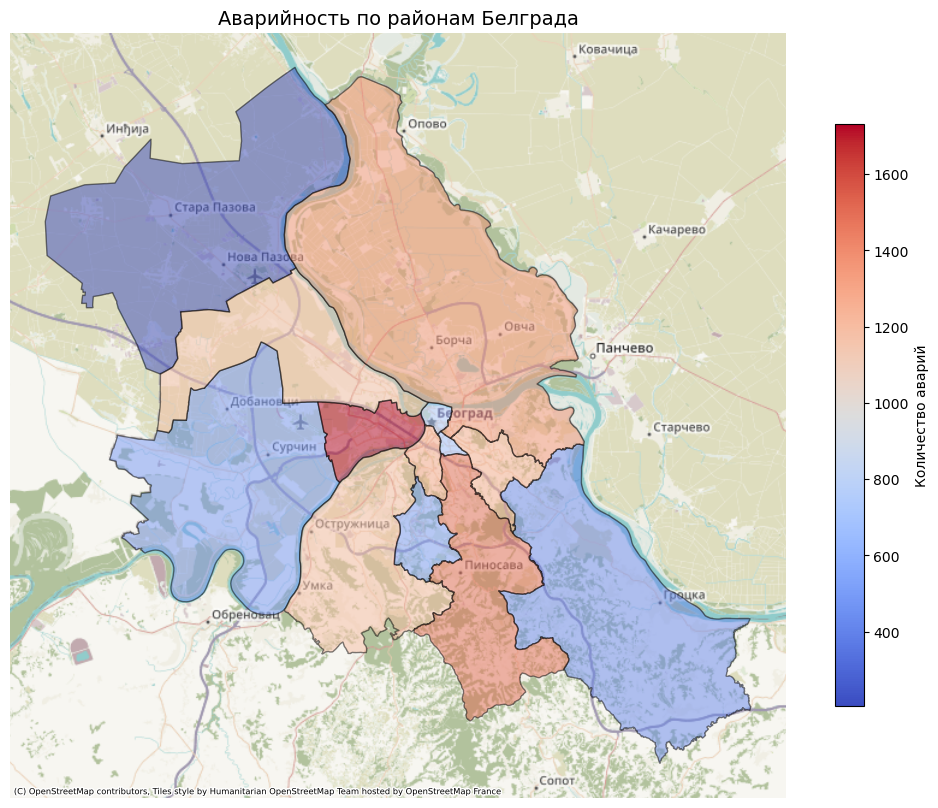

In [26]:
# Переводим полигоны (и при желании точки) в EPSG:3857
districts_web = districts_counts.to_crs(epsg=3857)

# crashes_web = crashes_joined.to_crs(epsg=3857)  # если вдруг тоже захочешь точки показать

fig, ax = plt.subplots(figsize=(10, 10))

# 3. Рисуем районы, окрашивая по числу аварий
districts_web.plot(
    column="n_crashes",
    ax=ax,
    alpha=0.5,
    edgecolor="black",
    cmap = 'coolwarm',
    legend=True,
    legend_kwds={
        "label": "Количество аварий",
        "shrink": 0.6
    }
)

# 4. Подкладываем тайлы карт
cx.add_basemap(
    ax,
    crs=districts_web.crs,  # важно — CRS должен быть 3857
    attribution_size=6
)

ax.set_title("Аварийность по районам Белграда", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


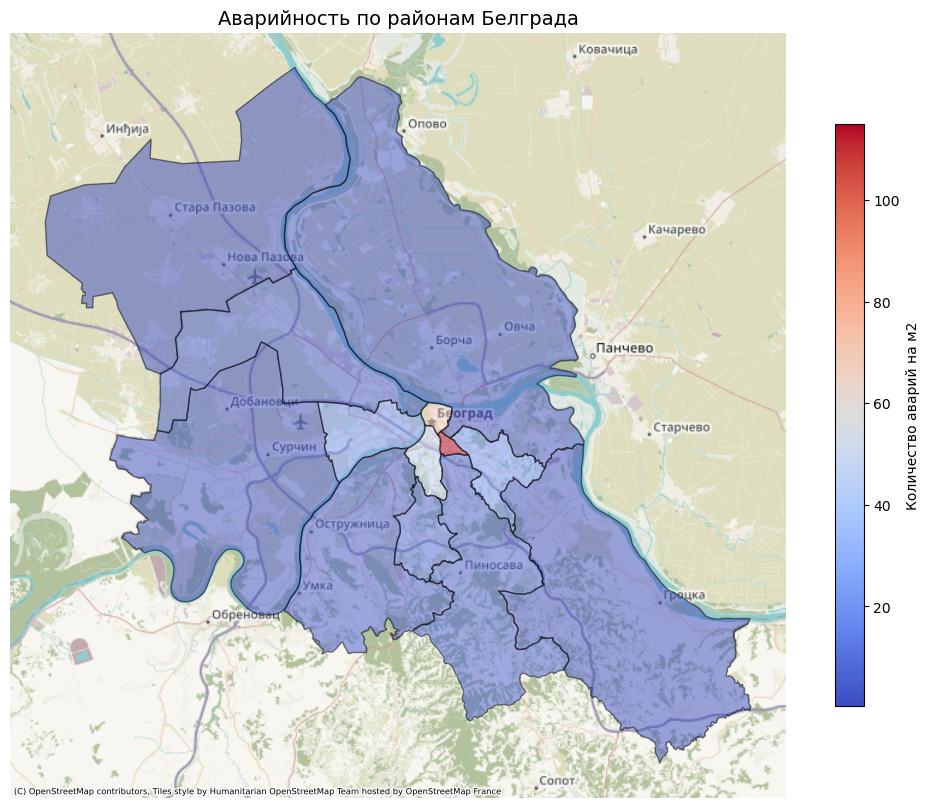

In [27]:
districts_web['area'] = districts_web['geometry'].apply(lambda x: x.area)
districts_web['crashes_per_area'] = (districts_web['n_crashes'] / districts_web['area']) * 1000000

fig, ax = plt.subplots(figsize=(10, 10))

# 3. Рисуем районы, окрашивая по числу аварий
districts_web.plot(
    column="crashes_per_area",
    ax=ax,
    alpha=0.5,
    edgecolor="black",
    cmap = 'coolwarm',
    legend=True,
    legend_kwds={
        "label": "Количество аварий на площадь",
        "shrink": 0.6
    }
)

# 4. Подкладываем тайлы карт
cx.add_basemap(
    ax,
    crs=districts_web.crs,  # важно — CRS должен быть 3857
    attribution_size=6
)

ax.set_title("Аварийность по районам Белграда", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [32]:
districts

geometry  \
element  id                                                           
relation 1635717  POLYGON ((20.01461 44.98004, 20.01462 44.98009...   
         2027114  POLYGON ((20.44358 44.82559, 20.44449 44.82743...   
         3065611  POLYGON ((20.53297 44.6808, 20.53299 44.6808, ...   
         3085424  POLYGON ((20.08789 44.78735, 20.0879 44.78738,...   
         3085749  POLYGON ((20.32574 44.83425, 20.32576 44.83425...   
         3085750  POLYGON ((20.14238 44.81115, 20.1424 44.81118,...   
         5731335  POLYGON ((20.46274 44.80756, 20.46274 44.80756...   
         5892891  POLYGON ((20.42479 44.79278, 20.42564 44.79362...   
         6930224  POLYGON ((20.47758 44.80472, 20.47759 44.80474...   
         7727516  POLYGON ((20.28757 44.66576, 20.28885 44.66682...   
         7728561  POLYGON ((20.41261 44.74189, 20.41273 44.74185...   
         7737268  POLYGON ((20.43556 44.64909, 20.43563 44.64913...   
         7737269  POLYGON ((20.28791 44.96667, 20.28771 44.96861...   

                                      int_name                          name  
element  id                                                                   
relation 1635717          Opstina Stara Pazova          Општина Стара Пазова  
         2027114    Gradska opstina Stari grad    Градска општина Стари град  
         3065611        Gradska opstina Grocka        Градска општина Гроцка  
         3085424        Gradska opstina Surcin        Градска општина Сурчин  
         3085749  Gradska opstina Novi Beograd  Градска општина Нови Београд  
         3085750         Gradska opstina Zemun         Градска општина Земун  
         5731335        Gradska opstina Vracar        Градска општина Врачар  
         5892891  Gradska opstina Savski venac  Градска општина Савски венац  
         6930224      Gradska opstina Zvezdara      Градска општина Звездара  
         7727516      Gradska opstina Cukarica      Градска општина Чукарица  
         7728561      Gradska opstina Rakovica      Градска општина Раковица  
         7737268      Gradska opstina Vozdovac      Градска општина Вождовац  
         7737269      Gradska opstina Palilula      Градска општина Палилула

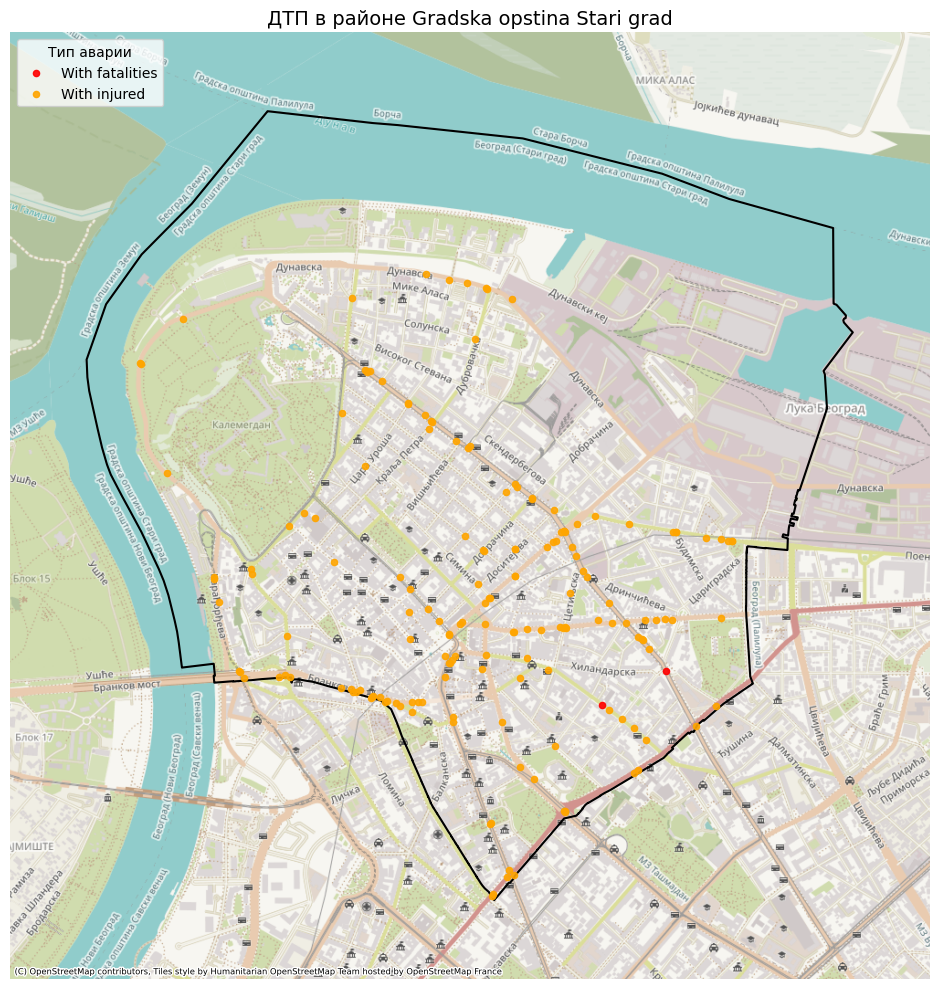

In [35]:
# 1. Фильтруем только нужный район по int_name
int_name = "Gradska opstina Stari grad"
district_nb = districts[districts["int_name"] == int_name].copy()
crashes_nb = crashes_joined[(crashes_joined["int_name"] == int_name) & (crashes_joined['type'] != "With material damage")].copy()

# 2. Перепроектируем в Web Mercator для подложки
district_nb_web = district_nb.to_crs(epsg=3857)
crashes_nb_web = crashes_nb.to_crs(epsg=3857)

# 3. Готовим палитру для типов аварий
type_colors = {
    "With fatalities": "red",
    "With injured": "orange",
    "With material damage": "yellow",
}

fig, ax = plt.subplots(figsize=(10, 10))

# 4. Рисуем полигон района (лёгкая заливка + граница)
district_nb_web.plot(
    ax=ax,
    facecolor="none",        # можно поставить alpha=0.2 и цвет, если хочется заливку
    edgecolor="black",
    linewidth=1.5,
)

# 5. Рисуем точки по типам аварий
for acc_type, color in type_colors.items():
    subset = crashes_nb_web[crashes_nb_web["type"] == acc_type]
    if subset.empty:
        continue
    subset.plot(
        ax=ax,
        markersize=20,
        marker="o",
        color=color,
        label=acc_type,
        alpha=0.9,
    )

# 6. Зумимся на район (немного отступов от границ)
minx, miny, maxx, maxy = district_nb_web.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

# 7. Добавляем подложку
cx.add_basemap(
    ax,
    crs=district_nb_web.crs,
    attribution_size=6,
)

ax.set_title("ДТП в районе " + int_name, fontsize=14)
ax.legend(title="Тип аварии", loc="upper left")
ax.set_axis_off()

plt.tight_layout()
plt.show()